# Denoising diffusion models

This is the main jupyter notebook for running the models for CIFAR10 and MNIST datasets.

### Imports

In [2]:
# system imports
import os
import warnings
# Disable general Python warnings
warnings.filterwarnings('ignore')

# import of external packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from typing import List

# import of custom classes
from diffusion_model import DiffusionModel
from dataset import DiffusionDataModule
from trainer import Trainer
from unet import SimpleModel
from schedule import LinearSchedule, CosineSchedule
from metrics import tfFIDScore
from classifier_guidance.diffusion_model_c import DiffClassifierGuidance
from classifier_guidance.test_mnist import MNISTGuidanceClassifier
from classifier_guidance.test_cifar10 import CIFAR10GuidanceClassifier
from classifier_free_guidance.unet_cf import SimpleModelClassFreeGuidance
from classifier_free_guidance.diffusion_model_cf import DiffClassifierFreeGuidance

# basic setup
PROJECT_BASE_DIR = os.path.dirname(os.getcwd())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on: ", device)

2024-12-19 14:23:46.112033: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 14:23:46.456627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 14:23:46.456680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 14:23:46.511829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 14:23:46.639215: I tensorflow/core/platform/cpu_feature_guar

Running on:  cuda


### Plotting functions

In [3]:
def denormalize_image(image: np.ndarray):
    '''
    Denormalize image from [-1, 1] to [0, 1]
    '''
    return (image + 1) / 2

def plot_forward_process(diffusion_model: DiffusionModel, x: torch.Tensor, t: List[int], 
                             title: str = 'Forward Process', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot the forward process of the diffusion model

    Inputs:
    - diffusion_model: Diffusion model
    - x: Single image as tensor [1, C, H, W]
    - t: List of time steps to plot
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    # create plot
    fig, ax = plt.subplots(1, len(t), figsize=(10,4))
    for idx in range(len(t)):
        x_t = diffusion_model.forward(x, t[idx])
        x_t = x_t.permute(0, 2, 3, 1).detach().cpu().numpy()
        if denormalize:
            x_t = denormalize_image(x_t)
        x_t = np.clip(x_t, 0, 1)
        ax[idx].imshow(x_t[0], cmap=cmap)
        ax[idx].axis('off')
        ax[idx].set_title(f't={t[idx]}')
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_reverse_process(samples: List[np.ndarray], t: List[int], 
                         title: str = 'Reverse Process', cmap: str = 'gray', denormalize: bool = True, T: int = 1000):
    '''
    Plot the reverse process of the diffusion model

    Inputs:
    - samples: List of samples of shape [num_samples, C, H, W] corresponding to all time steps
    - t: List of time steps to plot
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    - T: Total number of timesteps
    '''
    num_samples = len(samples[0])  # Number of samples in each timestep
    num_time_steps = len(t)        # Number of timesteps to plot

    # Create a grid of subplots
    fig, axes = plt.subplots(num_samples, num_time_steps, figsize=(num_time_steps * 3, num_samples * 3))
    
    # Handle cases where there's only one sample or one timestep
    if num_samples == 1:
        axes = np.expand_dims(axes, 0)  # Add an extra dimension for consistency
    if num_time_steps == 1:
        axes = np.expand_dims(axes, -1)

    for i in range(num_samples):  # Iterate over each sample
        for j, timestep in enumerate(t):  # Iterate over each selected timestep
            sample = np.transpose(samples[timestep][i], (1, 2, 0))  # Select the specific sample and timestep
            if denormalize:
                sample = denormalize_image(sample)  # Denormalize if required
            sample = np.clip(sample, 0, 1)  # Clip to valid range [0, 1]

            axes[i, j].imshow(sample, cmap=cmap)
            axes[i, j].axis('off')
            if i == 0:  # Only add titles for the first row
                axes[i, j].set_title(f't={T-timestep}')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_multiple_images(images: np.ndarray, 
                             title: str = 'Generated Images', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot multiple images in a grid

    Inputs:
    - images: numpy array of shape [B, C, H, W]. Shall be at least 5 images
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    # preprocessing for plot
    if images.shape[0] > 16:
        images = images[:16]
        print('Only the first 16 images will be plotted')
    num_rows = int(np.ceil(images.shape[0] / 4))

    if denormalize:
        images = denormalize_image(images)

    images = np.clip(images, 0, 1)

    # create plot
    fig, ax = plt.subplots(num_rows, 4, figsize=(10,10))
    for i in range(num_rows):
        for j in range(4):
            if num_rows > 1:
                if i*4+j < images.shape[0]:
                    img = np.transpose(images[i*4+j],(1,2,0))
                    ax[i,j].imshow(img, cmap=cmap)
                ax[i,j].axis('off')
            else:
                if j < images.shape[0]:
                    img = np.transpose(images[j],(1,2,0))
                    ax[j].imshow(img, cmap=cmap)
                ax[j].axis('off')
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

## Results for MNIST

### Initialize the datasets

In [4]:
# Initialize data module & get data loaders
data_module = DiffusionDataModule()
BATCH_SIZE = 128
train_loader_mnist, val_loader_mnist, test_loader_mnist = data_module.get_MNIST_data_split(
    batch_size=BATCH_SIZE,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

### How to train the model

In this part we showcase how to initialize the trainer and train a model from scratch. 

The full script that we used on the HPC with logging, saving plots, saving models locally etc. is located in `src/main.py`. In the next cell we will train for 1 epoch only, to demonstrate our code. 

In order to train models for CIFAR-10 one would have to increase the number of `out_ch` to 3 and change the `img_shape` to $(3, 32, 32)$.

In [5]:
# Initialize Model, Model Schedule and Diffusion Model
T = 1000
model = SimpleModel(ch_layer0=64, out_ch=1, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[], dropout=0.1, resamp_with_conv= True)
schedule = LinearSchedule(10e-4, 0.02, T)
diffusion_model = DiffusionModel(model, T=T, schedule=schedule, img_shape=(1, 28, 28))

# Inititalize trainer object
trainer = Trainer(
    model=diffusion_model,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    optimizer=torch.optim.Adam(diffusion_model.model.parameters(), lr=1e-4),
    num_epochs=1,
    normalized=True,
    validate="mnist"
)
model.to(device)

SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsample(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3-4): 2 x ResNetBlock(
      (norm1): GroupNorm(64, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_

In [14]:
# Train the model, get a logger out that can be used to create & save FID / Loss plots, 
# extract the best model concerning best validation Loss and FID score etc.
logger = trainer.train()
# Get the best model from the logger
diffusion_model = logger.best_model

100%|██████████| 422/422 [07:35<00:00,  1.08s/minibatch]


Epoch: 1 | Train Loss: 45.19047892150156


2024-12-19 14:31:30.029335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-19 14:31:30.037845: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Evaluate the trained model by computing the FID-score using activations from an MNIST classifier

In [ ]:
# Initialize FID-scorer class
scorer = tfFIDScore(mode='mnist') # possible modes are 'mnist' and 'cifar10'
fids_train, fids_test = [], []

# generate samples
samples = diffusion_model.sample(n_samples=BATCH_SIZE)

# iterate over training and test dataset
for minibatch_idx, (x, _) in enumerate(train_loader_mnist):
    if x.shape[0] == BATCH_SIZE:
        fids_train.append(scorer.calculate_fid(x, samples))

for minibatch_idx, (x, _) in enumerate(test_loader_mnist):
    if x.shape[0] == BATCH_SIZE:
        fids_test.append(scorer.calculate_fid(x, samples))

print(f'FID score on training set: {np.mean(fids_train)}')
print(f'FID score on test set: {np.mean(fids_test)}')

### Initialize the  best performing model for MNIST which was with Attention blocks and a Cosine schedule

We show our results by using a model that we have already trained as training from scratch would take too long.

In [5]:
model_path_mnist = os.path.join(PROJECT_BASE_DIR, "resources", "saved_models", "mnist", "mnist_unet.pth")

In [6]:
# Initialize diffusion model
T =1000 
model_mnist = SimpleModel(ch_layer0=64, out_ch=1, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[0,1,2], dropout=0.1, resamp_with_conv= True)
schedule_cosine = CosineSchedule(T)
diffusion_model_mnist = DiffusionModel(model_mnist, T=T, schedule=schedule_cosine, img_shape=(1, 28, 28))
diffusion_model_mnist.load(model_path_mnist)
model_mnist.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\resources\saved_models\mnist\mnist_unet.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): AttnBlock(
      (norm): GroupNorm(32, 64, eps=1e-05, affine=True)
      (q): Linear(in_features=64, out_features=64, bias=True)
      (k): Linear(in_features=64, out_features=64, bias=True)
      (v): Linear(in_features=64, out_features=64, bias=True)
      (proj_out): Linear(in_featu

### Plot the forward process

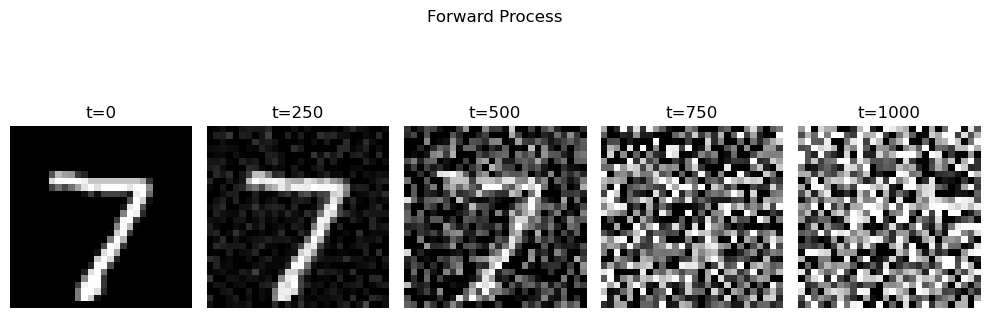

In [7]:
# Plot the samples
x, _ = next(iter(test_loader_mnist))
plot_forward_process(diffusion_model_mnist, x, [0, T//4, T//2, T*3//4, T], title='Forward Process', cmap='gray', denormalize=True)

### Plot reverse process

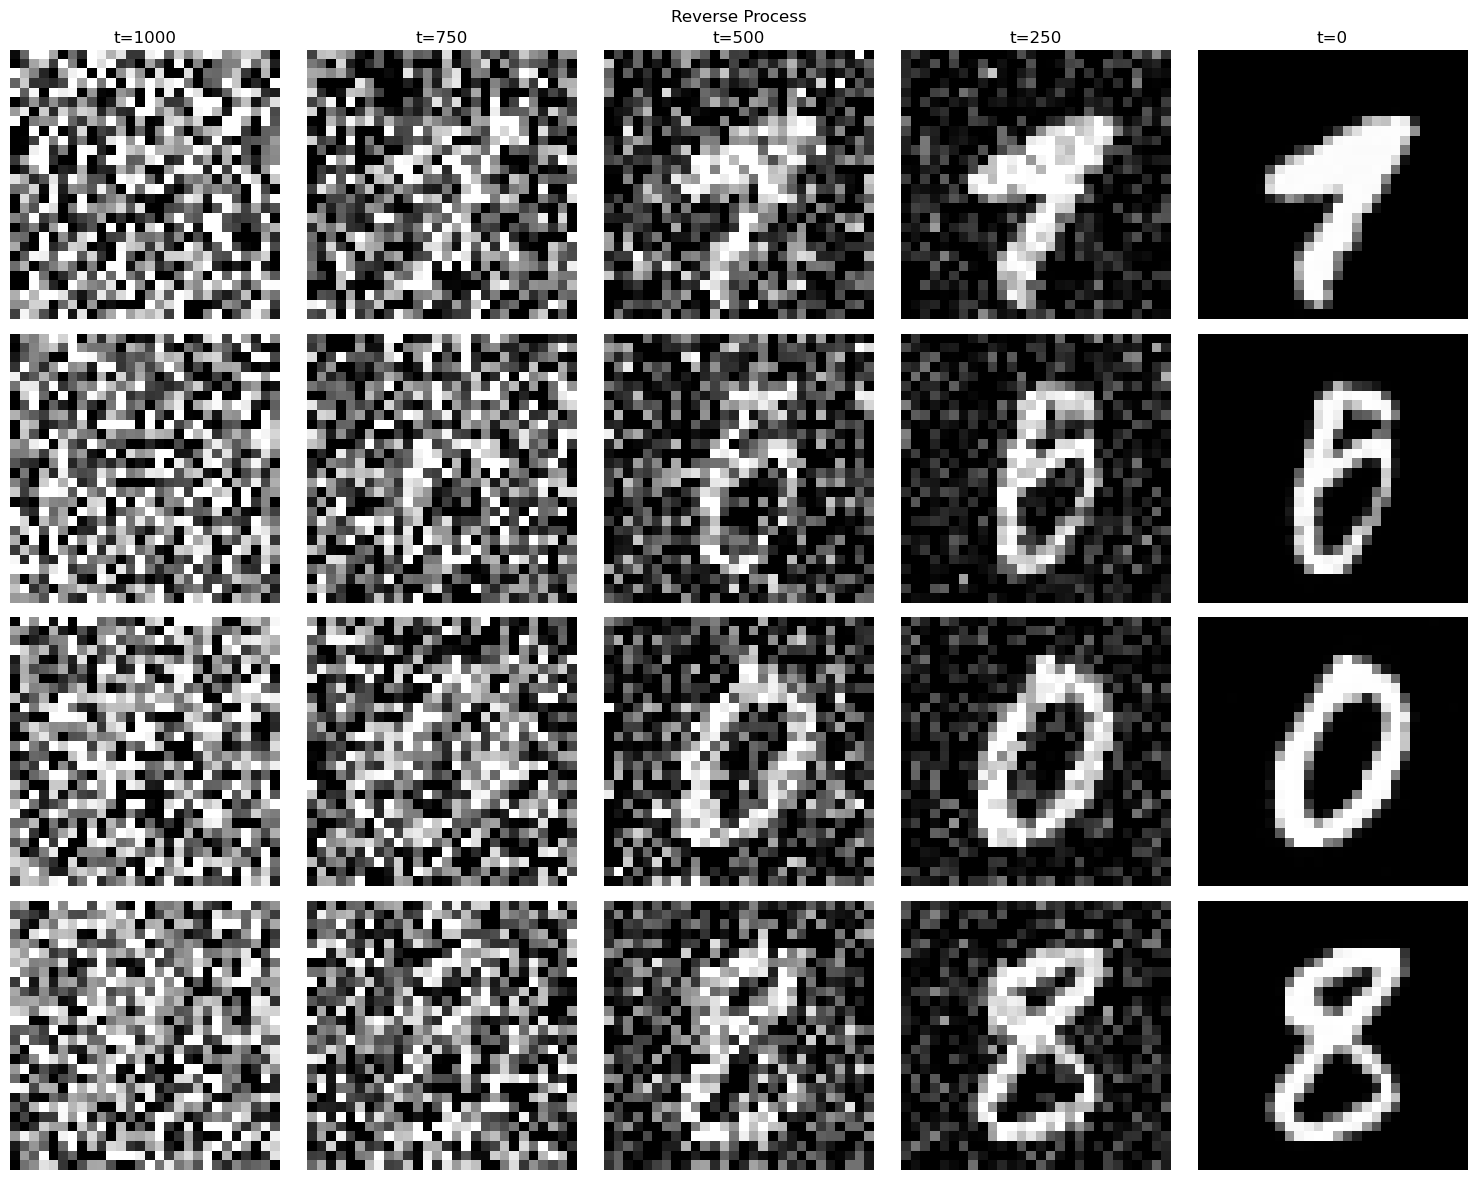

In [10]:
samples = diffusion_model_mnist.all_step_sample(n_samples=4)
plot_reverse_process(samples, [0, T//4, T//2, T*3//4, T], title='Reverse Process', cmap='gray', denormalize=True, T=T)

### Generate some image samples

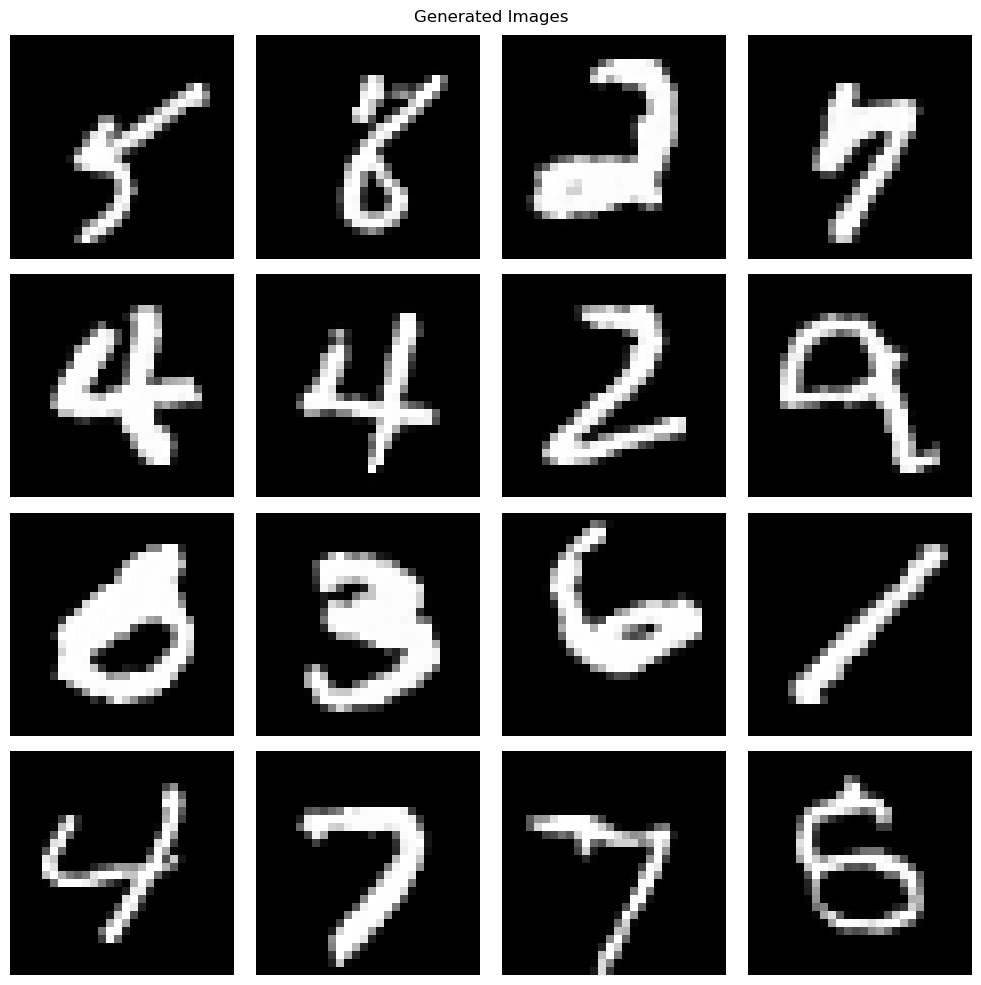

In [38]:
# Sample from the model
samples = diffusion_model_mnist.sample(n_samples=16)
plot_multiple_images(samples, title='Generated Images', cmap='gray', denormalize=True)

## Results for CIFAR-10

For CIFAR-10 we only visualize the results using a model that we have pretrained. To train a new model please follow the guided provided in the MNIST part of this notebook.

### Initialize the datasets

In [15]:
train_loader_cifar10, val_loader_cifar10, test_loader_cifar10 = data_module.get_CIFAR10_data_split(
    batch_size=128,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Initialize the  best performing model for CIFAR10 which was with no Attention blocks and a Linear schedule

In [16]:
model_path_cifar10 = os.path.join(PROJECT_BASE_DIR, "resources", "saved_models","cifar10", "cifar10_unet.pth")

In [17]:
# Initialize diffusion model
T =1000 
model_cifar10 = SimpleModel(ch_layer0=64, out_ch=3, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[], dropout=0.1, resamp_with_conv= True)
schedule_linear = LinearSchedule(10e-4, 0.02, T)
diffusion_model_cifar10 = DiffusionModel(model_cifar10, T=T, schedule=schedule_linear, img_shape=(3, 32, 32))
diffusion_model_cifar10.load(model_path_cifar10)
model_cifar10.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\resources\saved_models\cifar10\cifar10_unet.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsample(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3-4): 2 x ResNetBlock(
      (norm1): GroupNorm(64, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_

### Plot the forward process

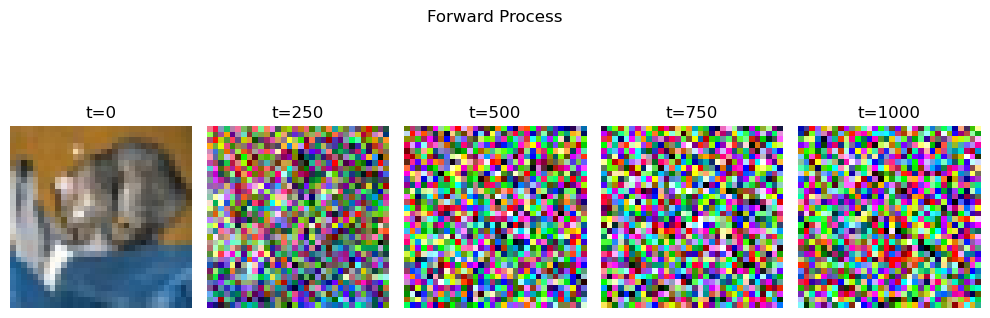

In [37]:
# Plot the samples
x, _ = next(iter(test_loader_cifar10))
plot_forward_process(diffusion_model_cifar10, x, [0, T//4, T//2, T*3//4, T], title='Forward Process', cmap=None, denormalize=True)

### Plot the reverse process

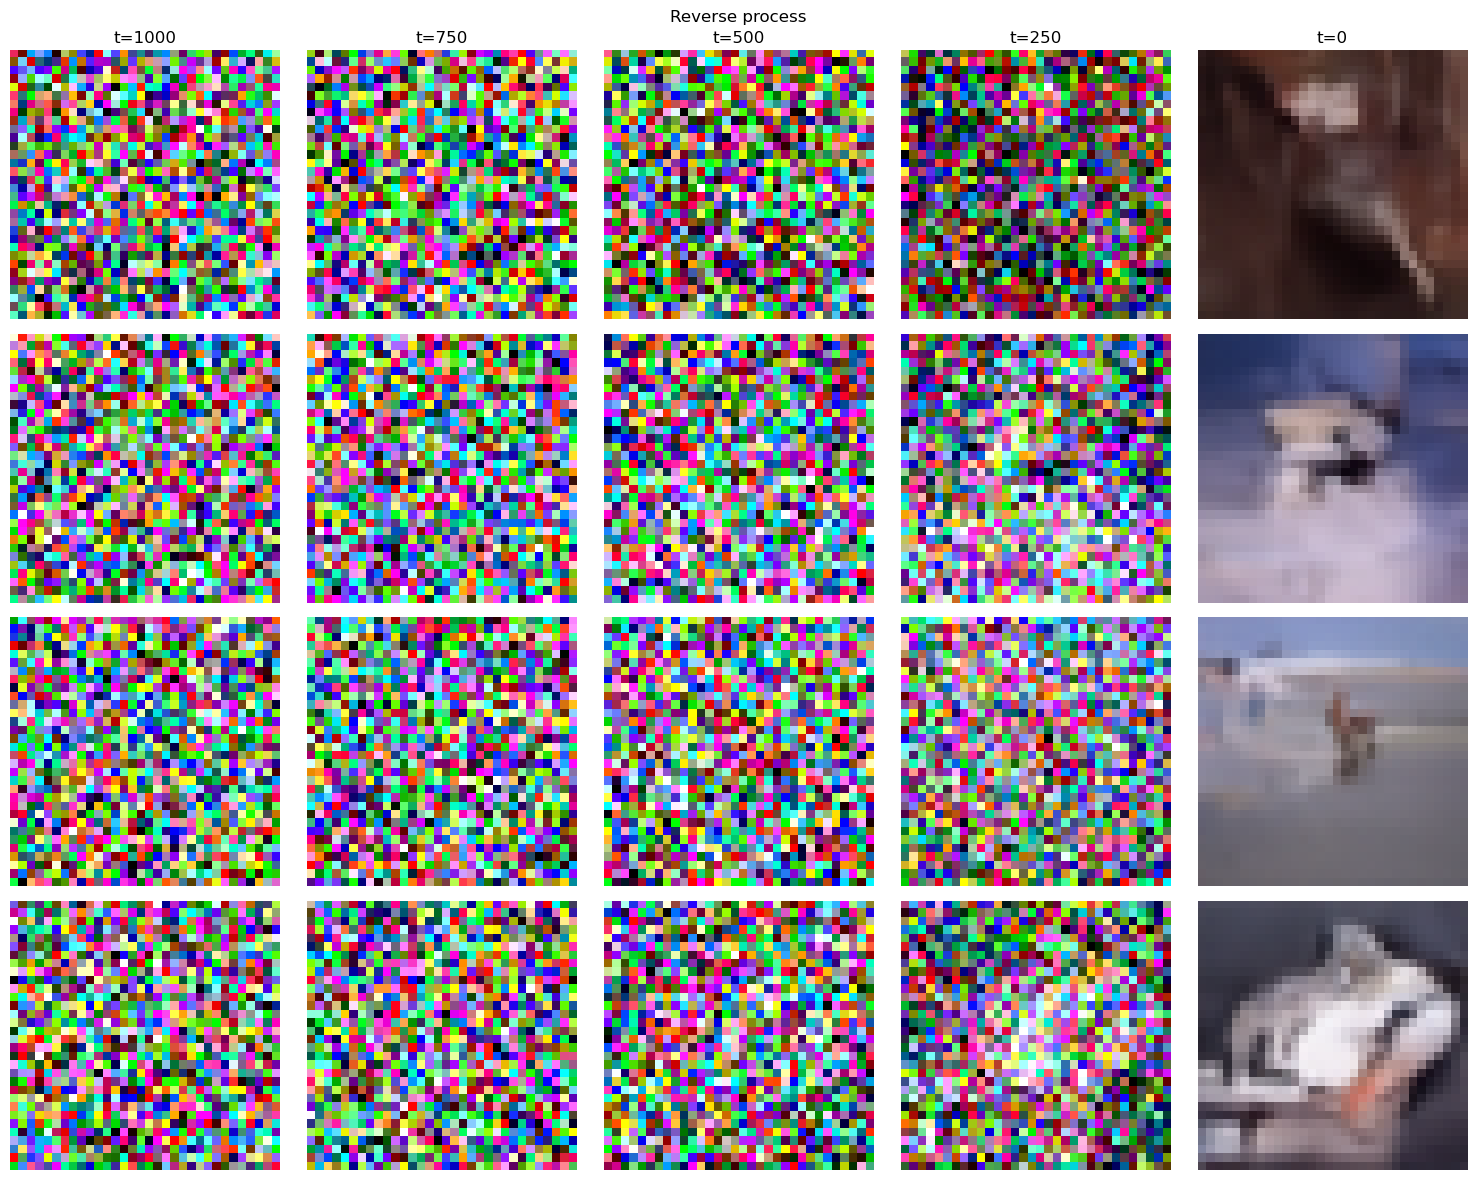

In [18]:
samples = diffusion_model_cifar10.all_step_sample(n_samples=4)
plot_reverse_process(samples, [0, T//4, T//2, T*3//4, T], title="Reverse process", cmap=None, denormalize=True)

### Generate some image samples

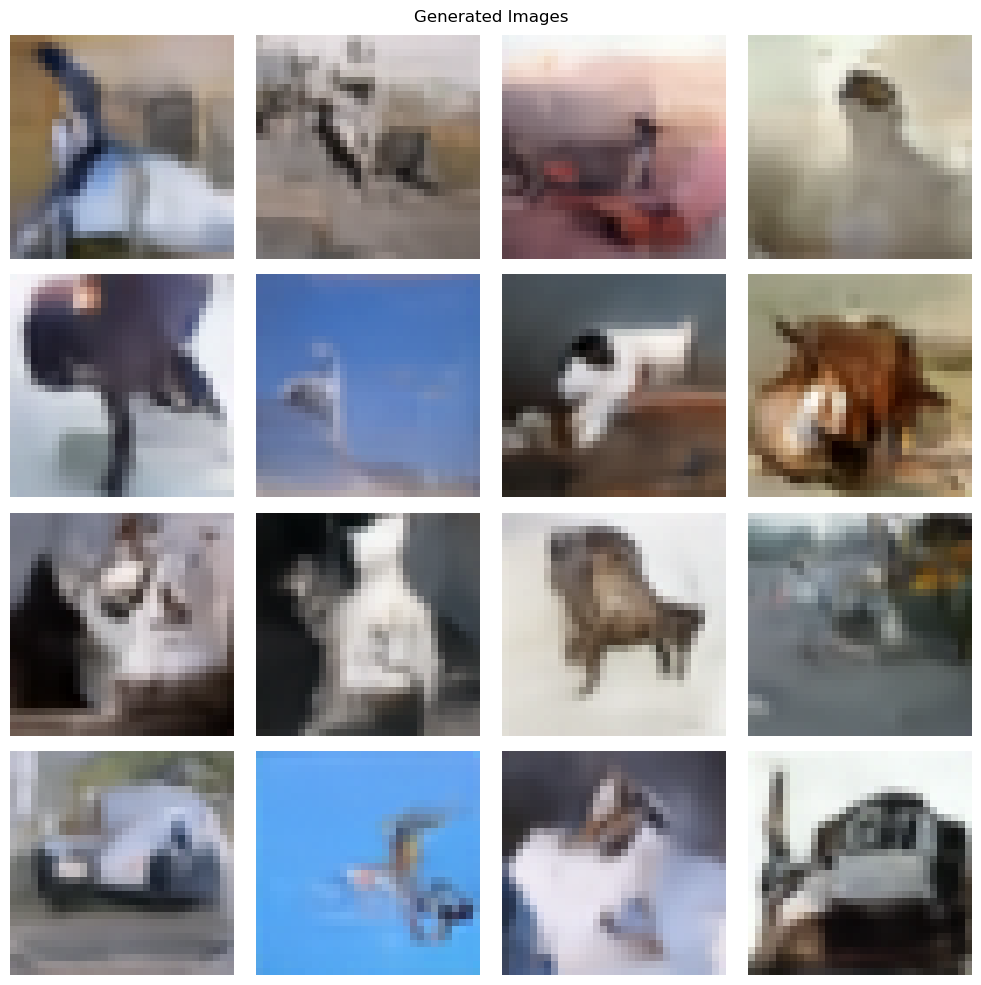

In [39]:
# Sample from the model
samples = diffusion_model_cifar10.sample(n_samples=16)
plot_multiple_images(samples, title='Generated Images', cmap=None, denormalize=True)

## Guided sampling

In this section we show our results utilizing guided sampling. We tried out 2 different approaches for this. One approach was to utilize a trained classifier to guide our sampling process, and another was to embedd class labels into our network and train this new model with additional embeddings.

To generate a desired class just change the *desired_class* variable in sampling cells.

### 1. Classifier guidance for sampling on MNIST and CIFAR10

In [10]:
classifier_mnist = MNISTGuidanceClassifier()
classifier_mnist.load_state_dict(torch.load(os.path.join(os.path.dirname(os.getcwd()),'resources','saved_models', 'mnist', 'mnist_guidance_classifier.pth'), weights_only=True))
T=1000
schedule_cosine = LinearSchedule(10e-4, 0.02, T)
model_mnist_linear = model = SimpleModel(ch_layer0=64, out_ch=1, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[], dropout=0.1, resamp_with_conv= True)
model_mnist_linear_path = os.path.join(os.path.dirname(os.getcwd()), "resources", "saved_models", "mnist", "mnist_unet_linear.pth")
diffusion_model_cg_mnist = DiffClassifierGuidance(model_mnist_linear, T=T, schedule=schedule_cosine, img_shape=(1, 28, 28), classifier=classifier_mnist, lambda_guidance=200)
diffusion_model_cg_mnist.load(model_mnist_linear_path)
model_mnist_linear.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\resources\saved_models\mnist\mnist_unet_linear.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsample(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3-4): 2 x ResNetBlock(
      (norm1): GroupNorm(64, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_

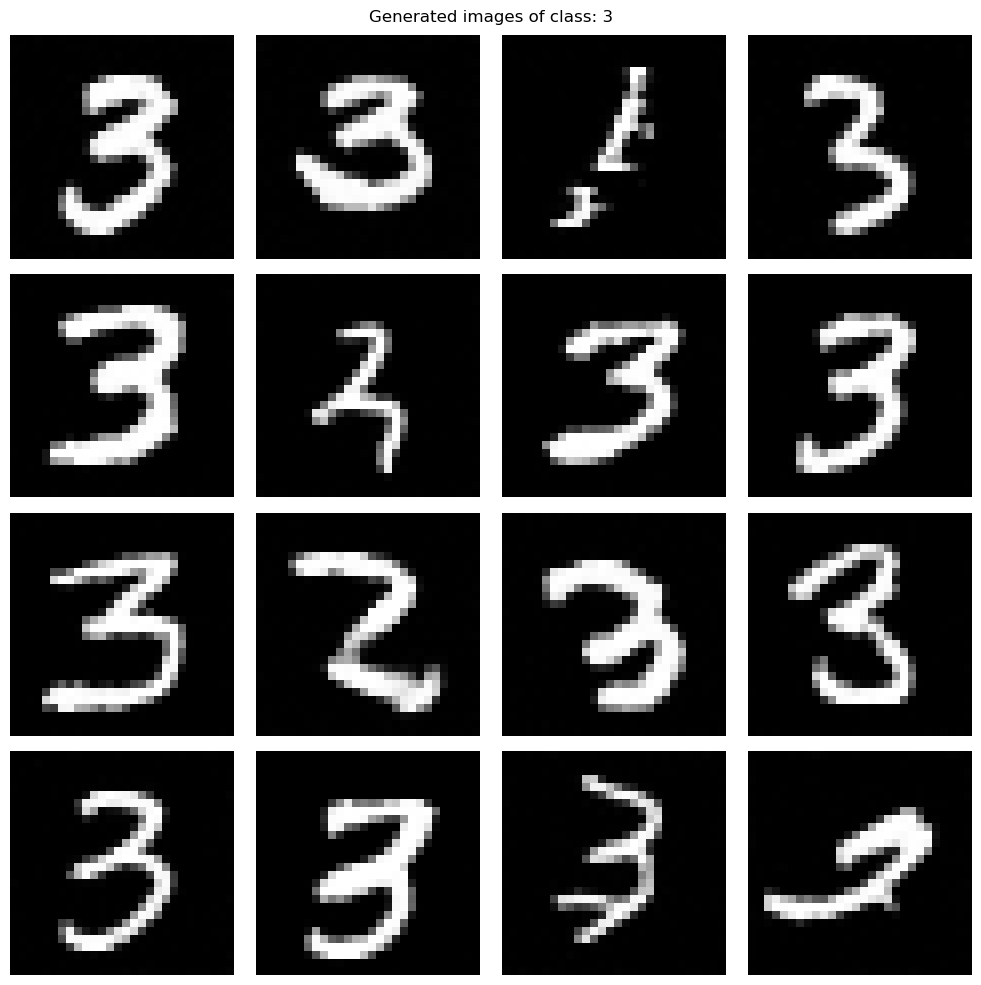

In [61]:
desired_class = 3
samples = diffusion_model_cg_mnist.sample(n_samples=16, class_label=desired_class)
plot_multiple_images(samples, title=f'Generated images of class: {desired_class}', cmap='gray', denormalize=True)

In [14]:
classifier_cifar10 = CIFAR10GuidanceClassifier()
classifier_cifar10.load_state_dict(torch.load(os.path.join(PROJECT_BASE_DIR,'resources','saved_models','cifar10','cifar10_guidance_classifier.pth'), weights_only=True))
T=1000
schedule_linear = LinearSchedule(10e-4, 0.02, T)
diffusion_model_cg_mnist = DiffClassifierGuidance(model_cifar10, T=T, schedule=schedule_linear, img_shape=(3, 32, 32), classifier=classifier_cifar10, lambda_guidance=200)

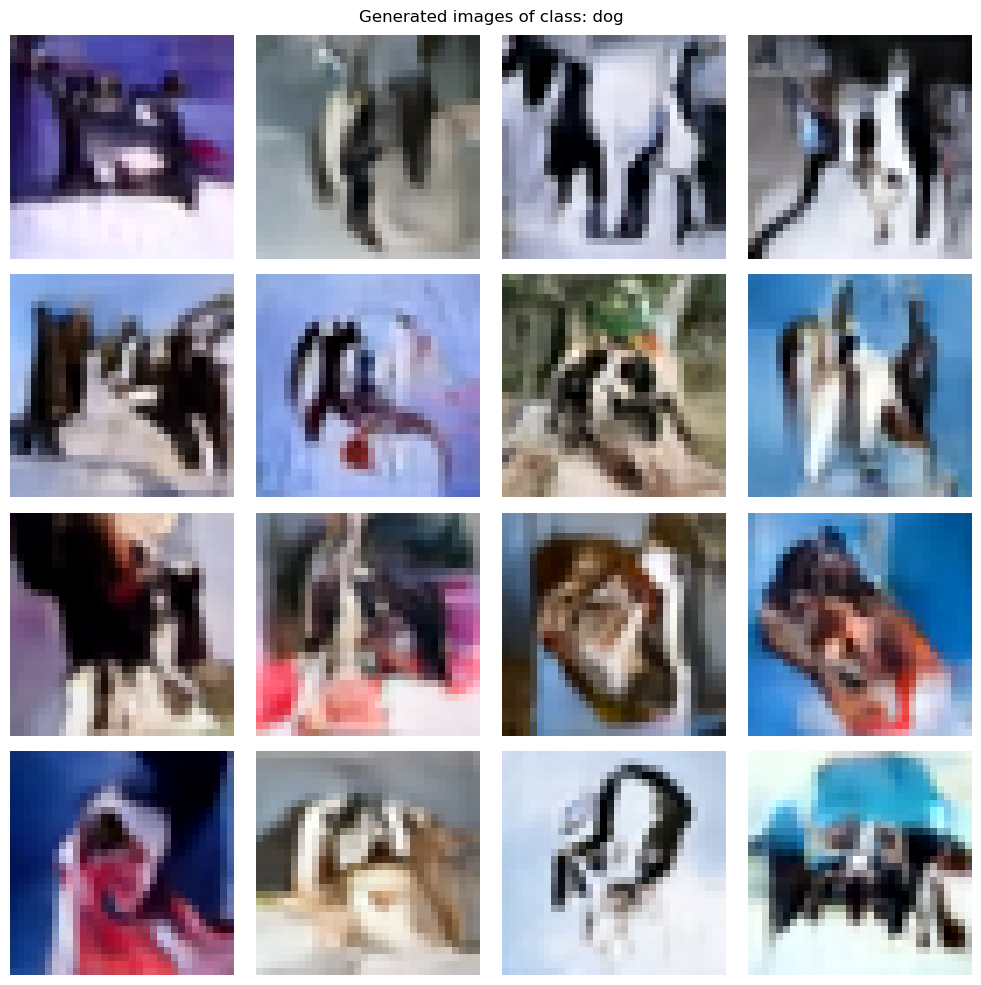

In [18]:
class_dict = {"airplane": 0, "automobile": 1, "bird": 2, "cat": 3, "deer": 4,
                  "dog": 5, "frog": 6, "horse": 7, "ship": 8, "truck": 9}
desired_class = "dog"
samples = diffusion_model_cg_mnist.sample(n_samples=16, class_label=class_dict[desired_class])
plot_multiple_images(samples, title=f'Generated images of class: {desired_class}', cmap='gray', denormalize=True)

### 2. Classifier-free guidance for MNIST

We have trained this model only for MNIST since we ran out of time to try it on CIFAR10.

In [40]:
model_mnist_cf = SimpleModelClassFreeGuidance(ch_layer0=32, out_ch=1, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[0,1,2], dropout=0.1, resamp_with_conv= True, lambda_cf=10.)
schedule_linear = LinearSchedule(10e-4, 0.02, T)
diffusion_model_mnist_cf = DiffClassifierFreeGuidance(model_mnist_cf, T=T, schedule=schedule_linear, img_shape=(1, 28, 28))
model_path_mnist_cf = os.path.join(PROJECT_BASE_DIR, "resources", "saved_models", "mnist", "mnist_unet_classifier_free.pth")
diffusion_model_mnist_cf.load(os.path.join(PROJECT_BASE_DIR, model_path_mnist_cf))

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\resources\saved_models\mnist\mnist_unet_classifier_free.pth


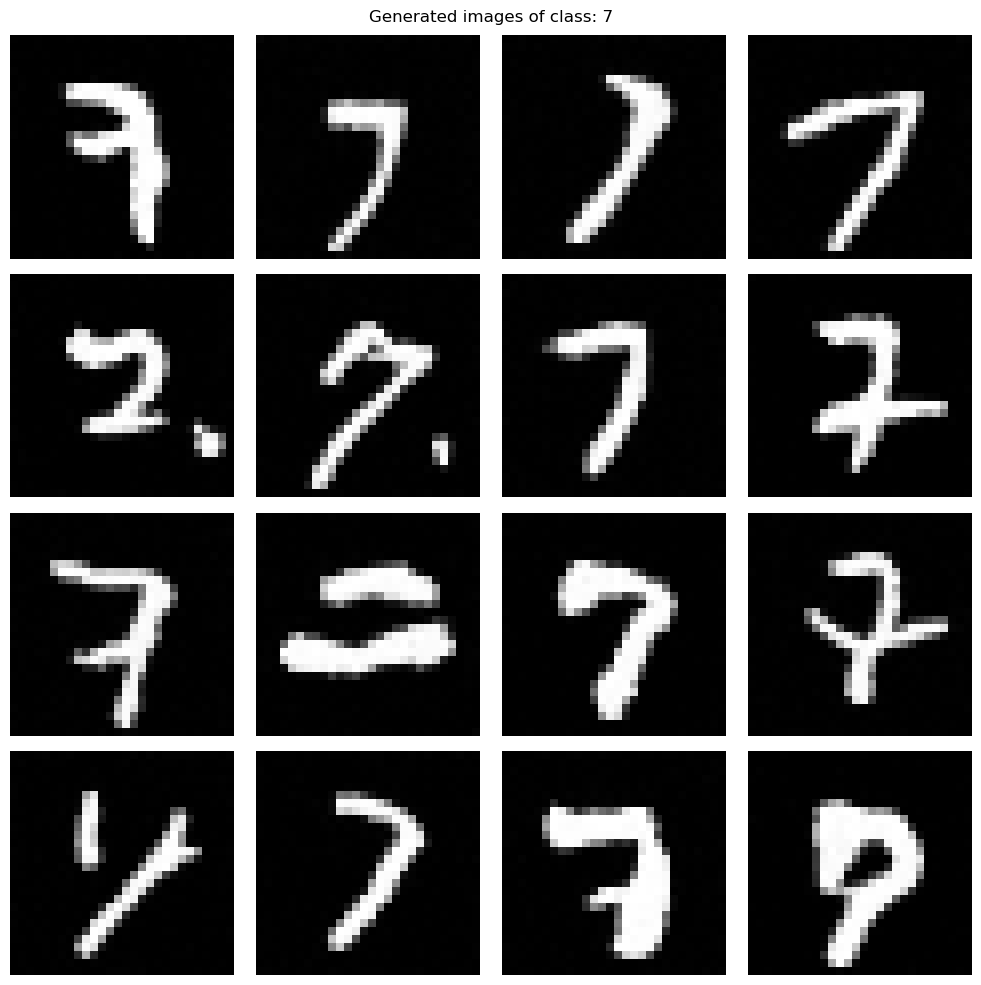

In [41]:
desired_class = 7
samples = diffusion_model_mnist_cf.sample(n_samples=16, class_label=torch.tensor([desired_class], dtype=torch.int).to(diffusion_model_mnist_cf.device))
plot_multiple_images(samples, title=f'Generated images of class: {desired_class}', cmap='gray', denormalize=True)